# Example notebook to showcase the usage of the Poisson VAE model

We showcase the model on a 10X ATAC sample dataset. The data can be downloaded from [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard).

## Load packages

In [1]:
1

1

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import scanpy as sc
import anndata as ad

You can install a forked version of `scvi-tools` with the Poisson VAE model from `https://github.com/lauradmartens/scvi-tools`. We will try to merge it with `scvi-tools` soon.
Run `pip install .` in the cloned repository.

In [4]:
import scvi

/home/icb/laura.martens/miniconda3/envs/scvi-tools/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
[rank: 0] Global seed set to 0
/home/icb/laura.martens/miniconda3/envs/scvi-tools/lib/python3.9/site-packages/pytorch_lightning/loggers/base.py:24: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  rank_zero_deprecation(


You will only need the `poisson_atac` package for diagnostic plots (e.g. distribution of counts). You can install the `poisson_atac` package from `https://github.com/theislab/scatac_poisson_reproducibility`.
Run `pip install .` in the cloned repository.

In [5]:
import poisson_atac as patac

In [6]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data'

## Load the data

In [35]:
adata = sc.read_10x_h5(os.path.join(data_path, '10X/10k_Human_PBMCs_ATAC_v2_Chromium_Controller', '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5'), gex_only=False)

## Plot count distributions

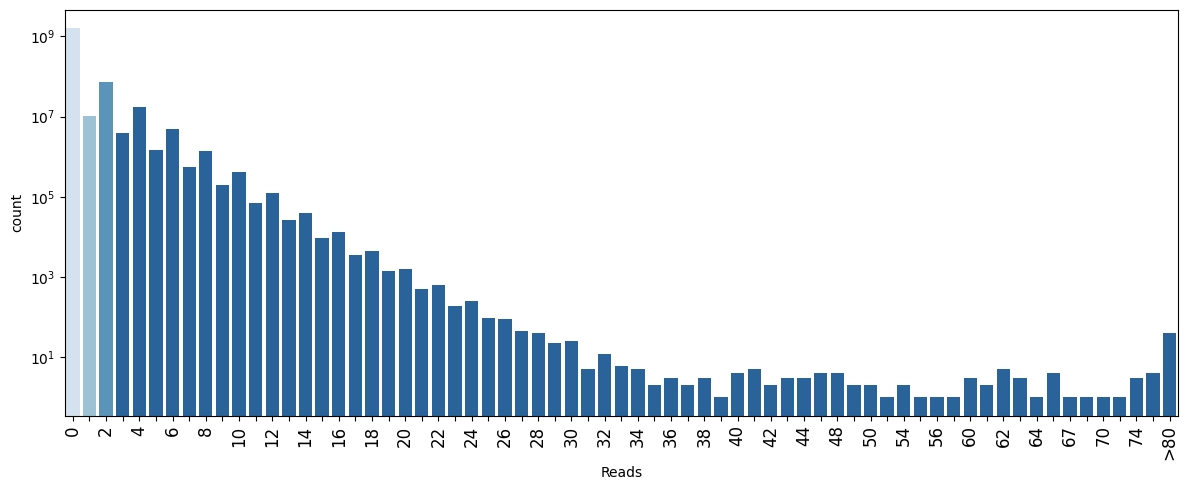

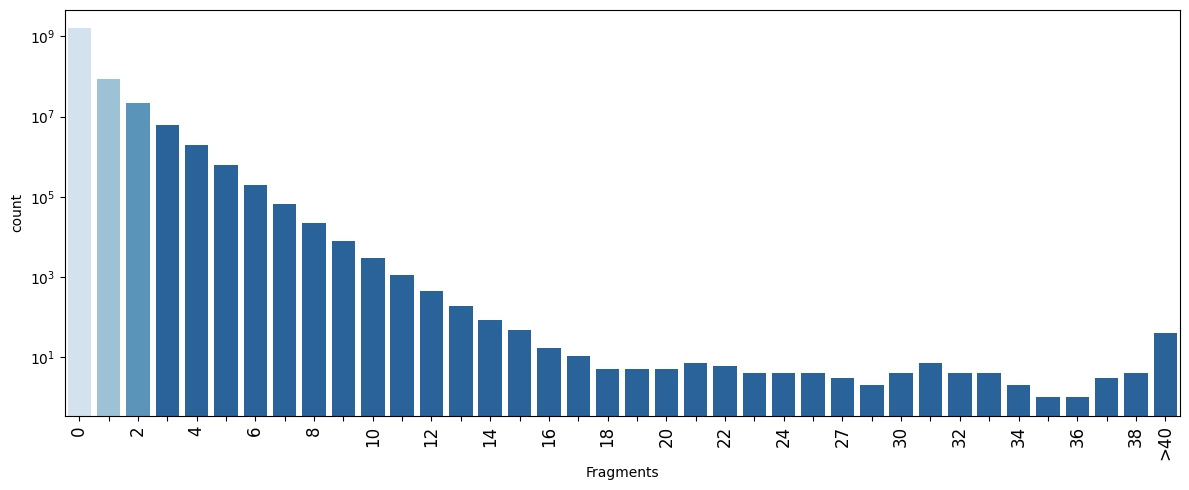

In [8]:
patac.pl.count_distribution(adata, figsize=(12, 5), limit=80)

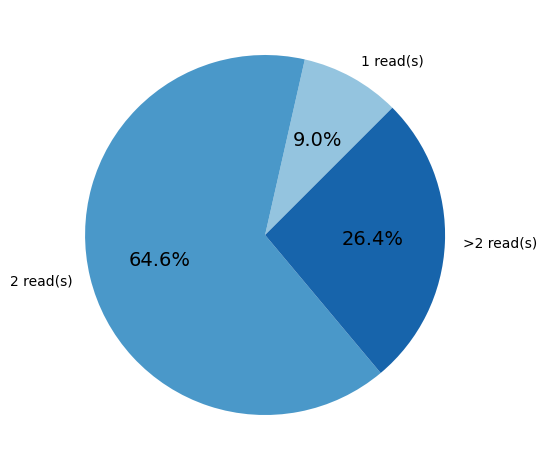

In [9]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=2)

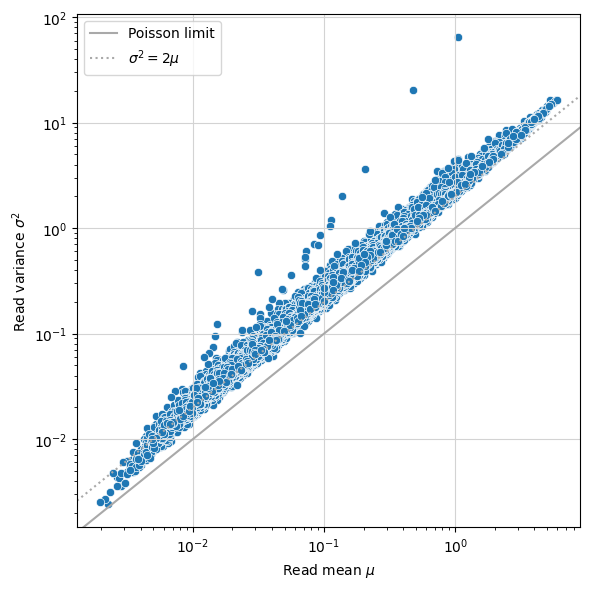

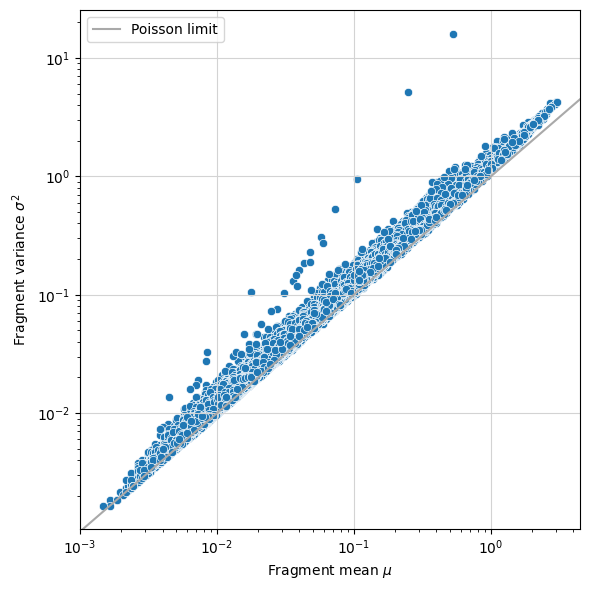

In [10]:
patac.pl.mean_variance(adata, figsize=(6,6))

## Convert to fragment counts

In [11]:
scvi.model.POISSONVI.reads_to_fragments(adata)

## Setup PoissonVAE model

The model is based on the scvi models. They have a great documentation at https://scvi-tools.org/. Here you will also find more information on the parameters you can use in the setup and training of the model.

In [12]:
scvi.model.POISSONVI.setup_anndata(adata, layer="counts") # if you have batches use batch='batch_key'

In [13]:
model = scvi.model.POISSONVI(adata)

In [14]:
model

PoissonVI Model with params: 
n_hidden: 406, n_latent: 20, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, latent_distribution: 
normal, deep injection: False, encode_covariates: False
Training status: Not Trained

## Train PoissonVAE model

In [16]:
model.train(train_size=0.8, validation_size=0.1)

/home/icb/laura.martens/miniconda3/envs/scvi-tools/lib/python3.9/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/laura.martens/miniconda3/envs/scvi-tools/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/laura.martens/miniconda3/envs/scvi-tools/lib/python3.9/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/laura.martens/miniconda3/envs/scvi-tools/l ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Epoch 99/500:  20%|█▉        | 99/500 [11:43<47:29,  7.11s/it, loss=3.43e+04, v_num=1] 
Monitored metric reconstruction_loss_validation did not improve in the last 45 records. Best score: 34721.578. Signaling Trainer to stop.


## Compute and plot embedding

In [17]:
# Get latent embedding of cells
X_emb = model.get_latent_representation(adata)
adata.obsm['X_emb'] = X_emb

In [18]:
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)

In [19]:
sc.tl.leiden(adata)

/home/icb/laura.martens/miniconda3/envs/scvi-tools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


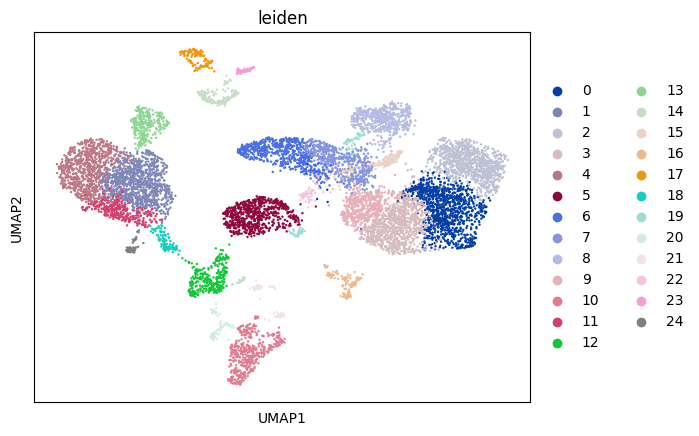

In [21]:
sc.pl.umap(adata, color="leiden")